In [1]:
!nvidia-smi

Sat Dec 31 15:38:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.11    Driver Version: 525.60.11    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN Xp     Off  | 00000000:02:00.0 Off |                  N/A |
| 23%   19C    P8     7W / 250W |      4MiB / 12288MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:17:00.0 Off |                  N/A |
| 47%   

In [ ]:
# installing dependencies, run only during first setup
% pip install torch torchvision pyyaml --extra-index-url https://download.pytorch.org/whl/cu116

In [ ]:
# run only during first setup
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!python -m pip install opencv-python

In [1]:
# setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import wandb

# import some common libraries
import numpy as np
import os, json, cv2, random
import glob
import pandas as pd

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader
from detectron2.structures import BoxMode, Instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
import math
import torch
from skimage.draw import ellipse, ellipse_perimeter

import matplotlib.pyplot as plt
%matplotlib inline

/mnt/SSD0/safal/AI_assisted_microscopy_system/codes/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!ls /mnt/Enterprise/safal/AI_assisted_microscopy_system

cysts_dataset_3  cysts_dataset_all  data_yolov5  outputs  Results


In [3]:
BASE_DIR = "/mnt/Enterprise/safal/AI_assisted_microscopy_system/"

In [4]:
SAMPLE_FILES = {
    'brightfield_reference': {
        'img_dir': 'cysts_dataset_all/brightfield_reference/train',
        'json_file': 'cysts_dataset_all/brightfield_reference/brightfield_reference.json',
    },
    'brightfield_sample': {
        'img_dir': 'cysts_dataset_all/brightfield_sample/train',
        'json_file': 'cysts_dataset_all/brightfield_sample/brightfield_sample.json',
    },
    'smartphone_reference': {
        'img_dir': 'cysts_dataset_all/smartphone_reference/train',
        'json_file': 'cysts_dataset_all/smartphone_reference/smartphone_reference.json',
    },
    'smartphone_sample': {
        'img_dir': 'cysts_dataset_all/smartphone_sample/train',
        'json_file': 'cysts_dataset_all/smartphone_sample/smartphone_sample.json',
    },
    'smartphone_sample_test': {
        'img_dir': 'cysts_dataset_all/smartphone_sample_test/test',
        'json_file': 'cysts_dataset_all/smartphone_sample_test/smartphone_sample_test.json',
    }
}

In [5]:
# change the type of sample study here
STUDY_SAMPLE = 'brightfield_reference'

In [6]:
# Defined a function to create a dictionary in a format accepted by detectron2
def get_cysts_dicts(img_dir, split, json_file_path):
    # load the JSON file
    with open(json_file_path) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    # loop through the entries in the JSON file
    for idx, v in enumerate(imgs_anns.values()):
        record = {}  # Initialize dict to add image name, image id and annotation in a format accepted by detectron2
        
        filename = os.path.join(img_dir, v["filename"])
        if os.path.isfile(filename):
          pass
        else:
          #print("Image not found", filename)
          continue
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        annos = v["regions"]

        objs = []
        # one image can have multiple annotations, therefore this loop is needed
        for annotation in annos:
            # reformat the polygon information to fit the specifications
            anno = annotation["shape_attributes"]
            cx = anno["cx"]
            cy = anno["cy"]
            rx= anno["rx"]
            ry=anno["ry"]
            theta =anno["theta"]
            region_attributes = annotation["region_attributes"]["Cyst-type"]
            xx,yy = ellipse_perimeter(cx, cy, round(rx), round(ry), orientation= theta)
            poly = [(x+0.5, y + 0.5) for x,y in zip(xx,yy)]
            poly = [p for x in poly for p in x]
            # specify the category_id to match with the class.

            if "Giardia" in region_attributes:
                category_id = 1
            elif "Crypto" in region_attributes:
                category_id = 0
            
            def ellipse_to_rectange(rx,ry,theta):
              ea = rx*math.cos(theta)
              eb = ry*math.sin(theta)
              ec = rx*math.sin(theta)
              ed = ry*math.cos(theta)
              width = math.sqrt(math.pow(ea,2)+math.pow(eb,2))*2
              height = math.sqrt(math.pow(ec,2)+math.pow(ed,2))*2
              return (width ,height)
            width , height = ellipse_to_rectange(rx,ry,theta)

            obj = {
                "bbox": [cx-width*0.5,cy-height*0.5,cx+width*0.5,cy+height*0.5],
                "bbox_mode": BoxMode.XYXY_ABS,
                #"segmentation": [poly],
                "segmentation": [],
                "category_id": category_id,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)

        total_file = 831
        block = total_file//5
        dataset_1 = dataset_dicts[0:block]
        dataset_2 = dataset_dicts[block:2*block]
        dataset_3 = dataset_dicts[2*block:3*block]
        dataset_4 = dataset_dicts[3*block:4*block]
        dataset_5 = dataset_dicts[4*block:5*block]
        #d = dataset_1 + dataset_2 + dataset_3 + dataset_4 
    print(f"Total images: {total_file}")
    # print(block)
    print(f"First fold: {len(dataset_1)}")
    print(f"Second fold: {len(dataset_2)}")
    print(f"Third fold: {len(dataset_3)}")
    print(f"Forth fold: {len(dataset_4)}")
    print(f"Fifth fold: {len(dataset_5)}")
    if split == "train":
      return dataset_1 + dataset_5 + dataset_2 + dataset_4
    if split == "val":
      return dataset_3


In [7]:
# Register the dataset in the format that can be processed by detectron2
for d in ["train", "val"]:
  DatasetCatalog.register("cysts_" + d, lambda d=d: get_cysts_dicts(BASE_DIR + SAMPLE_FILES[STUDY_SAMPLE]['img_dir'],d, BASE_DIR + SAMPLE_FILES[STUDY_SAMPLE]['json_file']))
  MetadataCatalog.get("cysts_" + d).set(thing_classes=["Crypto", "Giardia"])
cysts_metadata = MetadataCatalog.get("cysts_train")

In [18]:
MODEL = "faster_rcnn_X_101_32x8d_FPN_3x"

In [8]:
# creating an instance of config file and initializing model and model weight
cfg = get_cfg()

#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
#cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
model=cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
#cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")

In [9]:
# Use the registered dataset for training and validation 
cfg.DATASETS.TRAIN = ("cysts_train",)
cfg.DATASETS.TEST = ("cysts_val",)
cfg.DATALOADER.NUM_WORKERS = 4
#cfg.MODEL.MASK_ON = False

In [10]:
#import detectron2.data.transforms as T
#from detectron2.data import DatasetMapper
#from detectron2.data import build_detection_train_loader
# Can simply use this dataloader as all the required augmentation are present in DatasetMapper of detectron2
#dataloader = build_detection_train_loader(cfg, mapper= DatasetMapper(cfg, is_train = True, augmentations = [
                                                                                                          #T.RandomCrop("relative_range",[100.05,100.05]),
                                                                                                          #T.ResizeShortestEdge(short_edge_length=[640,672,704,736,768,800], max_size = 1333 , sample_style= "choice" ),
                                                                                                          #T.Resize((512,512)),
                                                                                                          #T.RandomFlip(prob=0.7),
                                                                                                          #T.RandomFlip(prob=0.4, horizontal = False, vertical= True)
                                                                                                          #T.RandomRotation(angle=[0,3], sample_style="range")
                                                                                                          #]))

In [11]:
# Since detectron2 does not provide default evaluator, we create one. 
class CocoTrainer(DefaultTrainer):

  @classmethod
  # def build_train_loader(cls, cfg):   # Define a custom train loader to use custom data augmentation
  #    return dataloader               # Return the dataloader with custom DatasetMapper as defined in previous shell

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder= None):

    if output_folder is None:
      output_folder = f"outputs/eval/{STUDY_SAMPLE}"
      os.makedirs(output_folder, exist_ok = True)
    
    return COCOEvaluator(dataset_name, cfg, False, output_folder)

  #def build_hooks(self):
   #     hooks = super().build_hooks()
    #    hooks.insert(-1,LossEvalHook(
     #       cfg.TEST.EVAL_PERIOD,
      #      self.model,
       #     build_detection_test_loader(
        #        self.cfg,
         #       self.cfg.DATASETS.TEST[0],
          #      DatasetMapper(self.cfg,True)
           # )
        #))
        #return hooks  

In [12]:
# we define following for convergence in optimizer
cfg.SOLVER.IMS_PER_BATCH =4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS =1200
cfg.SOLVER.MAX_ITER = 1500
cfg.SOLVER.STEPS = []
cfg.SOLVER.GAMMA = 0.05

In [13]:
# specify the number of classes and batch size per image
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE =51
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
#cfg.MODEL.RETINANET.NUM_CLASSES = 2
#cfg.MODEL.RETINANET.FOCAL_LOSS_GAMMA= 1.2
#cfg.MODEL.RETINANET.FOCAL_LOSS_ALPHA=0.93
#cfg.TEST.EVAL_PERIOD = 200

In [14]:
wandb.init(project="cysts", name=f"{STUDY_SAMPLE}_faster_rcnn_X_101_32x8d_FPN_3x", config=cfg, sync_tensorboard=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: thapaliya19. Use `wandb login --relogin` to force relogin


In [ ]:
# Train the custom trainer
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
cfg.OUTPUT_DIR = BASE_DIR + f"outputs/{STUDY_SAMPLE}"
os.makedirs(cfg.OUTPUT_DIR, exist_ok = True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

In [18]:
# Load weights and determine threshold for evaluation
cfg.OUTPUT_DIR = BASE_DIR + f"outputs/{STUDY_SAMPLE}"
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
#cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.8
predictor= DefaultPredictor(cfg)
val_metadata = MetadataCatalog.get("cysts_val")

[12/31 17:06:56 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /mnt/Enterprise/safal/AI_assisted_microscopy_system/outputs/brightfield_reference/model_final.pth ...


In [ ]:
# Run the evaluator with the train model
evaluator =COCOEvaluator("cysts_val", cfg, False, output_dir= cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg,"cysts_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

In [20]:
wandb.finish()

bbox/AP,▁
bbox/AP-Crypto,▁
bbox/AP-Giardia,▁
bbox/AP50,▁
bbox/AP75,▁
bbox/APs,▁
data_time,▄▆▂▃▅▄▇▄▃▄▄▃▄▃▄▄▅▅▃▄▄▄▄▅▅▅▆▅▃▄▅▃▄▆▁█▄▁▂▅
eta_seconds,██▇█▇▇▇▇▇▆▆▆▇▆▆▆▆▅▅▅▄▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
fast_rcnn/cls_accuracy,▁█▇▇█▇▇▇▇███████████████████████████████
fast_rcnn/false_negative,▁███████▆▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁
fast_rcnn/fg_cls_accuracy,▄▁▁▁▁▁▁▁▃▄▅▆▆▇██▇▇█▇▇███████████████████


## Save the model

In [26]:
# To save the pickle file such that it can be loaded in cpu (Later, when it is used) 
cfg.MODEL.DEVICE = "cpu"
cfg.MODEL.RPN.BBOX_REG_LOSS_TYPE = "smooth_l1"
cfg.MODEL.RPN.BBOX_REG_LOSS_WEIGHT = 1.0
cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_LOSS_TYPE = "smooth_l1"
cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_LOSS_WEIGHT = 1.0

In [27]:
# Save the cfg with the model and its weights.  
import pickle
filename = os.path.join(BASE_DIR, f'outputs/{STUDY_SAMPLE}/faster_rcnn_X_101_32x8d_FPN_3x.pkl')
with open(filename, 'wb') as f:
     pickle.dump(cfg, f)

# TESTING

## Load the model


In [14]:
# Load the model
import pickle
filename = os.path.join(BASE_DIR, f'outputs/{STUDY_SAMPLE}/faster_rcnn_X_101_32x8d_FPN_3x.pkl')
with open(filename, 'rb') as f:
     cfg = pickle.load(f)
predictor = DefaultPredictor(cfg)
val_metadata = MetadataCatalog.get("cysts_val")

[01/02 10:30:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /mnt/Enterprise/safal/AI_assisted_microscopy_system/outputs/brightfield_reference/model_final.pth ...


In [15]:
# Function to filter the objects according to area of bounding boxes 
def filter_by_area(output):
  filtered_instances =[]     #list to accomodate all the filtered instances(After comparing predicted bounding box area with the actual area)
  instance_copy = output["instances"] # Get the copy of all the instances
  length = len(instance_copy)
  if length == 0:
    return instance_copy
  
  for i in range(length): # Loop over all the instances
    if instance_copy[i].pred_classes.item() == 0: # for crypto
      pred_box = instance_copy[i].pred_boxes   
      area_box = pred_box.area()      # Calculate the area using default function
      if area_box>126.88 and area_box<304.48: # condition to match area crypto    Area --> Average of all the ground truth bounding boxes on training images (Crypto)
        filtered_instances.append(instance_copy[i])
    
    elif instance_copy[i].pred_classes.item() == 1:  # for Giardia
      pred_box = instance_copy[i].pred_boxes
      area_box = pred_box.area()
      if area_box>543.676 and area_box<1624.8813: # condition to match area giardia.  Area --> Average of all the ground truth bounding boxes on training images (Giardia)
        filtered_instances.append(instance_copy[i])
  if not filtered_instances:
    return instance_copy[0]
  total_instances=Instances.cat(filtered_instances) # concatenate all the instances from a static method Instances
  return total_instances

SS_TEST0000.jpg
filtered_number: Giardia = 0 	 Cryptosporidium = 0 

PREDICTED_NUMBERS:Giardia =0 
 Cryptosporidium= 0 

ACTUAL_NUMBERS:Giardia =0 
 Cryptosporidium= 2 
0
0
SS_TEST0001.jpg
filtered_number: Giardia = 0 	 Cryptosporidium = 0 

PREDICTED_NUMBERS:Giardia =0 
 Cryptosporidium= 0 

ACTUAL_NUMBERS:Giardia =0 
 Cryptosporidium= 0 
0
0
SS_TEST0002.jpg
filtered_number: Giardia = 0 	 Cryptosporidium = 0 

PREDICTED_NUMBERS:Giardia =0 
 Cryptosporidium= 0 

ACTUAL_NUMBERS:Giardia =1 
 Cryptosporidium= 0 
0
0
SS_TEST0003.jpg
filtered_number: Giardia = 0 	 Cryptosporidium = 0 

PREDICTED_NUMBERS:Giardia =0 
 Cryptosporidium= 0 

ACTUAL_NUMBERS:Giardia =0 
 Cryptosporidium= 1 
0
0
SS_TEST0004.jpg
filtered_number: Giardia = 0 	 Cryptosporidium = 0 

PREDICTED_NUMBERS:Giardia =0 
 Cryptosporidium= 0 

ACTUAL_NUMBERS:Giardia =1 
 Cryptosporidium= 0 
0
0
SS_TEST0005.jpg
filtered_number: Giardia = 0 	 Cryptosporidium = 0 

PREDICTED_NUMBERS:Giardia =0 
 Cryptosporidium= 0 

ACTUAL_NUMBERS

Invalid SOS parameters for sequential JPEG


filtered_number: Giardia = 0 	 Cryptosporidium = 0 

PREDICTED_NUMBERS:Giardia =0 
 Cryptosporidium= 0 

ACTUAL_NUMBERS:Giardia =2 
 Cryptosporidium= 0 
0
0
SS_TEST0069.jpg


Invalid SOS parameters for sequential JPEG


filtered_number: Giardia = 0 	 Cryptosporidium = 0 

PREDICTED_NUMBERS:Giardia =0 
 Cryptosporidium= 0 

ACTUAL_NUMBERS:Giardia =0 
 Cryptosporidium= 0 
0
0
SS_TEST0070.jpg
filtered_number: Giardia = 0 	 Cryptosporidium = 0 

PREDICTED_NUMBERS:Giardia =0 
 Cryptosporidium= 0 

ACTUAL_NUMBERS:Giardia =1 
 Cryptosporidium= 2 
0
0
SS_TEST0071.jpg
filtered_number: Giardia = 0 	 Cryptosporidium = 0 

PREDICTED_NUMBERS:Giardia =0 
 Cryptosporidium= 0 

ACTUAL_NUMBERS:Giardia =0 
 Cryptosporidium= 2 
0
0
SS_TEST0072.jpg
filtered_number: Giardia = 0 	 Cryptosporidium = 0 

PREDICTED_NUMBERS:Giardia =0 
 Cryptosporidium= 0 

ACTUAL_NUMBERS:Giardia =1 
 Cryptosporidium= 0 
0
0
SS_TEST0073.jpg
filtered_number: Giardia = 0 	 Cryptosporidium = 0 

PREDICTED_NUMBERS:Giardia =0 
 Cryptosporidium= 0 

ACTUAL_NUMBERS:Giardia =2 
 Cryptosporidium= 1 
0
0
SS_TEST0074.jpg
filtered_number: Giardia = 0 	 Cryptosporidium = 0 

PREDICTED_NUMBERS:Giardia =0 
 Cryptosporidium= 0 

ACTUAL_NUMBERS:Giardia =2 
 Cr

Invalid SOS parameters for sequential JPEG


filtered_number: Giardia = 0 	 Cryptosporidium = 0 

PREDICTED_NUMBERS:Giardia =0 
 Cryptosporidium= 0 

ACTUAL_NUMBERS:Giardia =1 
 Cryptosporidium= 0 
0
0
SS_TEST0076.jpg
filtered_number: Giardia = 0 	 Cryptosporidium = 0 

PREDICTED_NUMBERS:Giardia =0 
 Cryptosporidium= 0 

ACTUAL_NUMBERS:Giardia =2 
 Cryptosporidium= 3 
0
0
SS_TEST0077.jpg
filtered_number: Giardia = 0 	 Cryptosporidium = 0 

PREDICTED_NUMBERS:Giardia =0 
 Cryptosporidium= 0 

ACTUAL_NUMBERS:Giardia =1 
 Cryptosporidium= 0 
0
0
SS_TEST0078.jpg
filtered_number: Giardia = 0 	 Cryptosporidium = 0 

PREDICTED_NUMBERS:Giardia =0 
 Cryptosporidium= 0 

ACTUAL_NUMBERS:Giardia =0 
 Cryptosporidium= 0 
0
0
SS_TEST0079.jpg
filtered_number: Giardia = 0 	 Cryptosporidium = 0 

PREDICTED_NUMBERS:Giardia =0 
 Cryptosporidium= 0 

ACTUAL_NUMBERS:Giardia =1 
 Cryptosporidium= 0 
0
0
SS_TEST0080.jpg
filtered_number: Giardia = 0 	 Cryptosporidium = 0 

PREDICTED_NUMBERS:Giardia =0 
 Cryptosporidium= 0 

ACTUAL_NUMBERS:Giardia =3 
 Cr

Invalid SOS parameters for sequential JPEG


filtered_number: Giardia = 0 	 Cryptosporidium = 0 

PREDICTED_NUMBERS:Giardia =0 
 Cryptosporidium= 0 

ACTUAL_NUMBERS:Giardia =1 
 Cryptosporidium= 0 
0
0
SS_TEST0090.jpg
filtered_number: Giardia = 0 	 Cryptosporidium = 0 

PREDICTED_NUMBERS:Giardia =0 
 Cryptosporidium= 0 

ACTUAL_NUMBERS:Giardia =4 
 Cryptosporidium= 2 
0
0
SS_TEST0091.jpg
filtered_number: Giardia = 0 	 Cryptosporidium = 0 

PREDICTED_NUMBERS:Giardia =0 
 Cryptosporidium= 0 

ACTUAL_NUMBERS:Giardia =0 
 Cryptosporidium= 1 
0
0
SS_TEST0092.jpg
filtered_number: Giardia = 0 	 Cryptosporidium = 0 

PREDICTED_NUMBERS:Giardia =0 
 Cryptosporidium= 0 

ACTUAL_NUMBERS:Giardia =0 
 Cryptosporidium= 1 
0
0
SS_TEST0093.jpg
filtered_number: Giardia = 0 	 Cryptosporidium = 0 

PREDICTED_NUMBERS:Giardia =0 
 Cryptosporidium= 0 

ACTUAL_NUMBERS:Giardia =0 
 Cryptosporidium= 2 
0
0
SS_TEST0094.jpg
filtered_number: Giardia = 0 	 Cryptosporidium = 0 

PREDICTED_NUMBERS:Giardia =0 
 Cryptosporidium= 0 

ACTUAL_NUMBERS:Giardia =1 
 Cr

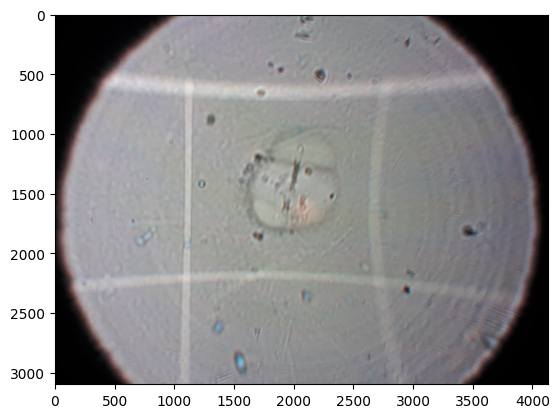

In [20]:
output_check=[]
total_crypto=0
total_giardia = 0
prediction_save_dir = os.path.join(BASE_DIR, 'prediction_images', STUDY_SAMPLE, MODEL)
os.makedirs(prediction_save_dir, exist_ok=True)
#for index, img_name in enumerate(glob.glob('/content/drive/My Drive/cysts_dataset/val/*.jpg')):
json_file = BASE_DIR + SAMPLE_FILES['smartphone_sample_test']['json_file']
with open(json_file) as f:
  imgs_anns = json.load(f)  

data_frame = pd.DataFrame(columns = ["file_name", "actual_Giardia","pred_Giardia","actual_Crypto","pred_Crypto"])  

for index, img_name in enumerate(imgs_anns.values()): #Count the actual number of Giardia and Cryptosporidium in the images
  actual_giardia, actual_crypto = 0,0 
  regions = img_name["regions"]
  for region_attributes in regions:
    if region_attributes["region_attributes"]["cysts"] == "Giardia":
      actual_giardia +=1
    elif region_attributes["region_attributes"]["cysts"] == "Crypto":
      actual_crypto += 1
  
#for index, img_name in enumerate(glob.glob("/content/drive/My Drive/cysts_dataset/val/*.jpg")):  
  print(img_name["filename"])
  im = cv2.imread(os.path.join(BASE_DIR, SAMPLE_FILES['smartphone_sample_test']['img_dir'],img_name["filename"]))
  outputs = predictor(im)
  output_check.append(outputs)
  filtered_instances = filter_by_area(outputs)
  v= Visualizer(im[:, :, ::-1],
                metadata = val_metadata,
                scale = 1)
  #out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  out= v.draw_instance_predictions(filtered_instances.to("cpu"))
  plt.imshow(out.get_image()[:, :, ::-1])
  plt.savefig(os.path.join(prediction_save_dir, img_name["filename"]))

  out_class_f= filtered_instances.pred_classes.tolist()
  f_giardia, f_crypto = 0,0
  for classes in out_class_f:
    if classes == 0:
      f_crypto += 1
      total_crypto +=1
    elif classes ==1:
      f_giardia += 1
      total_giardia +=1
  print(f"filtered_number: Giardia = {f_giardia} \t Cryptosporidium = {f_crypto} \n")
  
  out_class = outputs["instances"].pred_classes.tolist()  # Count the number of predicted Giardia and Cryptosporidium by the model
  pred_giardia, pred_crypto = 0,0
  for classes in out_class:
    if classes == 0:
      pred_crypto+=1
     
    elif classes ==1:
      pred_giardia+=1
      
  print(f"PREDICTED_NUMBERS:Giardia ={pred_giardia} \n Cryptosporidium= {pred_crypto} \n" )
  print(f"ACTUAL_NUMBERS:Giardia ={actual_giardia} \n Cryptosporidium= {actual_crypto} ")
  
  # Record data into dataframe to display later
  data_frame.loc[index,"file_name"] = img_name["filename"]
  data_frame.loc[index,"actual_Giardia"]= actual_giardia
  data_frame.loc[index,"pred_Giardia"]= pred_giardia
  data_frame.loc[index,"actual_Crypto"]= actual_crypto
  data_frame.loc[index,"pred_Crypto"]= pred_crypto
  print(total_crypto)
  print(total_giardia)

In [ ]:
dataset_val=get_cysts_dicts("/content/drive/My Drive/cysts_dataset_3/train/",'val')

In [ ]:
dataset_val[0]

## Cross validation prediction

In [ ]:
output_check=[]
output_images= []
total_g, total_c =0,0 

for t in dataset_val:                 # Loop over all the validation images
  
  actual_g, actual_c = 0,0       # To get the actual number of giardia and cryptosporidium 
  images = t
  annos = t['annotations']   #all annotations of ground truth
  for a in range(len(annos)):
    if images['annotations'][a]['category_id'] == 0:
      actual_c += 1
    else:
      actual_g += 1
  
  # This block of code is used to predict the objects in image from the trained model
  # Block starts
  file_name = t["file_name"]    
  print(file_name)
  im = cv2.imread(file_name)
  outputs = predictor(im)
  output_check.append(outputs)
  output_images.append(file_name)
  v= Visualizer(im[:, :, ::-1],
                metadata = val_metadata,
                scale = 1)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2.imshow(out.get_image()[:, :, ::-1])
  # Block ends

  out_class = outputs["instances"].pred_classes.tolist()  # Count the number of predicted Giardia and Cryptosporidium by the model
  pred_giardia, pred_crypto = 0,0
  for classes in out_class:
    if classes == 0:
      pred_crypto+=1
      total_c +=1
     
    elif classes ==1:
      pred_giardia+=1
      total_g +=1 
      
  print(f"PREDICTED_NUMBERS:Giardia ={pred_giardia} \n Cryptosporidium= {pred_crypto} \n" )
  print(f"ACTUAL_NUMBERS:Giardia ={actual_g} \n Cryptosporidium= {actual_c} ")
print(f"total_giardia: {total_g}")
print(f"total_crypto: {total_c}")

In [ ]:
len(output_check)

## Annotation count

In [ ]:
count_giardia =[]
count_crypto =[]
for r in dataset_val:
  image = r
  anno = r['annotations']   #all annotations of ground truth
  for a in range(len(anno)):
    if image['annotations'][a]['category_id'] == 0:
      count_crypto.append(0)
    else:
      count_giardia.append(1)
print(f"total_annotation_Giardia: {len(count_giardia)}")
print(f"total_annotation_Crypto: {len(count_crypto)}")
total_anno_g = len(count_giardia)
total_anno_c =len(count_crypto)

##Calculation of F1 score

In [ ]:
# Import necessary libraries
from detectron2.structures import Boxes
from detectron2.structures import pairwise_iou
g_count=0

In [ ]:
def calculate_parameters(iou_output, gt_class, pred_class):
  TP_g = 0
  FP_g = 0
  TP_c =0
  FP_c =0
  p_count = 0

  for i in iou_output.numpy():
    
    if not np.any(i):   # If all the values in the row of iou_output is 0 then it is a false positive(check if it is predicted as giardia or cryptosporidium) 
      if pred_class[p_count] == 0:
          FP_c +=1
      elif pred_class[p_count] == 1:
          FP_g +=1
      p_count +=1     
      continue 
    i_list= i.tolist()  # converting numpy array to list to get the max value and index
    max_value = max(i_list)  
    index = i_list.index(max_value)
    if pred_class[p_count] == gt_class[index] and max_value>0.5:     # Only condition to be true positive(compare predicted class with ground truth class and compare the IOU)
        if pred_class[p_count] == 0:
            TP_c +=1
        else:
            TP_g +=1
    else:
        if pred_class[p_count]== 0:
            FP_c +=1
        else:
            FP_g +=1 
    p_count +=1
  print(f"TP_g : {TP_g}")
  print(f"FP_g: {FP_g}")  
  print(f"TP_c : {TP_c}")  
  print(f"FP_c : {FP_c}") 
  return TP_g, TP_c, FP_g, FP_c 

In [ ]:
true_giardia=[] 
true_crypto= [] 
false_giardia= [] 
false_crypto=[]
#Loop over all the ouput and ground truth
for i in range(len(dataset_val)):
  gt_img = dataset_val[i]
  gt_anno = dataset_val[i]['annotations']   #all annotations of ground truth
  bboxs = []        # to append ground truth bounding boxes
  gt_class =[]      #  to append ground truth classes
  for a in range(len(gt_anno)):
    bboxs.append(gt_img['annotations'][a]['bbox'])
    gt_class.append(gt_img['annotations'][a]['category_id'])

  bboxs = np.array(bboxs)  # Converting the list into numpy array
  b_torch=torch.from_numpy(bboxs)  # Converting the numpy array into tensors
  b_boxes= Boxes(b_torch)  # Converting the tensors into detectron2 boxes

  #print(f"Ground_truth {bboxs}")
  #print(f"Ground_truth_class{g_class}")

  #filename = d["file_name"]
  #im = cv2.imread(filename)
  #print(bboxs[0])

  #output_img = predictor(im)  # Use the predictor to predict the image
  output_img = output_check[i]                 # Get the output 
  pred_box=output_img['instances'].pred_boxes.to("cpu")
  pred_class=output_img["instances"].pred_classes.tolist()
  #print(f"\n predicted {pred_box}")
  print(f"\n file_name: {gt_img['file_name']}")
  print(f" pred_class {pred_class}")
  print(f" g_class {gt_class}")

  iou_output = pairwise_iou(pred_box,b_boxes)   # Calculate the IOU of each bounding box(returns in the size (b_boxes X pred_box))
  print(iou_output)
  TP_g, TP_c , FP_g, FP_c =calculate_parameters(iou_output,gt_class, pred_class)
  true_giardia.append(TP_g)
  true_crypto.append(TP_c)
  false_giardia.append(FP_g)
  false_crypto.append(FP_c)

In [ ]:
np_true_giardia = np.array(true_giardia)
np_true_crypto = np.array(true_crypto)
np_false_giardia = np.array(false_giardia)
np_false_crypto = np.array(false_crypto)
print(f"true_giardia: {np_true_giardia.sum()}")
print(f"true_crypto: {np_true_crypto.sum()}")
print(f"false_giardia: {np_false_giardia.sum()}")
print(f"false_crypto: {np_false_crypto.sum()}")

## For Test dataset

In [ ]:
import glob
import os
count=0
images_path = '/content/drive/My Drive/cysts_dataset_2/test_image(brightfield)'
image_files =glob.glob(os.path.join(images_path, "*.png"))
for i in range(len(image_files)):
  print(image_files[i])
  im = cv2.imread(image_files[i])
  outputs = predictor(im)
  v= Visualizer(im[:, :, ::-1],
                metadata = val_metadata,
                scale = 1)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])
  count +=1
print(count)


## SAMPLE TEST

In [ ]:
# Function to filter the objects according to area of bounding boxes
def filter_by_area(output):
  filtered_instances =[]     #list to accomodate all the filtered instances(After comparing predicted bounding box area with the actual area)
  instance_copy = output["instances"] # Get the copy of all the instances
  length = len(instance_copy)
  if length == 0:
    return instance_copy
  
  for i in range(length): # Loop over all the instances
    if instance_copy[i].pred_classes.item() == 0: # for crypto
      pred_box = instance_copy[i].pred_boxes   
      area_box = pred_box.area()      # Calculate the area using default function
      if area_box>126.88 and area_box<304.48: #condition to match area crypto
        filtered_instances.append(instance_copy[i])
    
    elif instance_copy[i].pred_classes.item() == 1:  # for Giardia
      pred_box = instance_copy[i].pred_boxes
      area_box = pred_box.area()
      if area_box>543.676 and area_box<1624.8813: #condition to match area giardia
        filtered_instances.append(instance_copy[i])
  if not filtered_instances:
    return instance_copy[0]
    #pass

  total_instances=Instances.cat(filtered_instances) # concatenate all the instances from a static method Instances
  return total_instances

In [ ]:
import glob
import os
count=0
output_check = []
output_images = []
output_filtered =[]

# images_path = '/content/drive/My Drive/cysts_dataset_2/picture_jpeg'
# image_files =glob.glob(os.path.join(images_path, "*.jpg"))

for i in dataset_val:
  actual_g, actual_c = 0,0       # To get the actual number of giardia and cryptosporidium 
  images = i
  annos = i['annotations']   #all annotations of ground truth
  for a in range(len(annos)):
    if images['annotations'][a]['category_id'] == 0:
      actual_c += 1
    else:
      actual_g += 1

  file_name = i["file_name"]
  print(file_name)
  im = cv2.imread(file_name)
  outputs = predictor(im)
  output_check.append(outputs)
  # filtered_instances = filter_by_area(outputs)
  
  # output_filtered.append(filtered_instances)
  output_images.append(file_name)
  
  out_class = outputs["instances"].pred_classes.tolist()  # Count the number of predicted Giardia and Cryptosporidium by the model
  pred_giardia, pred_crypto = 0,0
  for classes in out_class:
    if classes == 0:
      pred_crypto+=1
     
    elif classes ==1:
      pred_giardia+=1

  # out_class_filtered = filtered_instances.pred_classes.tolist()  # Count the filtered number of Giardia and Cryptosporidium
  # giardia_filter, crypto_filter = 0,0
  # for classe in out_class_filtered:
  #   if classe == 0:
  #     crypto_filter += 1
  #   elif classe == 1:
  #     giardia_filter += 1 
  v= Visualizer(im[:, :, ::-1],
                metadata = val_metadata,
                scale = 1)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  # out = v.draw_instance_predictions(filtered_instances.to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])
  count +=1
  print(f"Actual Giardia:{actual_g} \t Crypto: {actual_c} \n")
  print(f"Predicted Giardia:{pred_giardia} \t Crypto: {pred_crypto} \n")
  # print(f"Filtered Giardia: {giardia_filter} \t Crypto: {crypto_filter}")
print(count)


In [ ]:
len(output_check)

## TP and FP

In [ ]:
# Import necessary libraries
from detectron2.structures import Boxes
from detectron2.structures import pairwise_iou
g_count=0

In [ ]:
def calculate_parameters(iou_output, gt_class, pred_class):
  TP_g = 0
  FP_g = 0
  TP_c =0
  FP_c =0
  p_count = 0

  for i in iou_output.numpy():
    
    if not np.any(i):   # If all the values in the row of iou_output is 0 then it is a false positive(check if it is predicted as giardia or cryptosporidium) 
      if pred_class[p_count] == 0:
          FP_c +=1
      elif pred_class[p_count] == 1:
          FP_g +=1
      p_count +=1     
      continue 
    i_list= i.tolist()  # converting numpy array to list to get the max value and index
    max_value = max(i_list)  
    index = i_list.index(max_value)
    if pred_class[p_count] == gt_class[index] and max_value>0.5:     # Only condition to be true positive(compare predicted class with ground truth class and compare the IOU)
        if pred_class[p_count] == 0:
            TP_c +=1
        else:
            TP_g +=1
    else:
        if pred_class[p_count]== 0:
            FP_c +=1
        else:
            FP_g +=1 
    p_count +=1
  print(f"TP_g : {TP_g}")
  print(f"FP_g: {FP_g}")  
  print(f"TP_c : {TP_c}")  
  print(f"FP_c : {FP_c}") 
  return TP_g, TP_c, FP_g, FP_c 

In [ ]:
true_giardia=[] 
true_crypto= [] 
false_giardia= [] 
false_crypto=[]
#Loop over all the ouput and ground truth
for i in range(len(dataset_val)):
  gt_img = dataset_val[i]
  gt_anno = dataset_val[i]['annotations']   #all annotations of ground truth
  bboxs = []        # to append ground truth bounding boxes
  gt_class =[]      #  to append ground truth classes
  for a in range(len(gt_anno)):
    bboxs.append(gt_img['annotations'][a]['bbox'])
    gt_class.append(gt_img['annotations'][a]['category_id'])

  bboxs = np.array(bboxs)  # Converting the list into numpy array
  b_torch=torch.from_numpy(bboxs)  # Converting the numpy array into tensors
  b_boxes= Boxes(b_torch)  # Converting the tensors into detectron2 boxes

  #print(f"Ground_truth {bboxs}")
  #print(f"Ground_truth_class{g_class}")

  #filename = d["file_name"]
  #im = cv2.imread(filename)
  #print(bboxs[0])

  #output_img = predictor(im)  # Use the predictor to predict the image
  # output_img = output_check[i]                 # Get the output  Use this when the output instances are not filtered
  # pred_box=output_img['instances'].pred_boxes.to("cpu")
  # pred_class=output_img["instances"].pred_classes.tolist()
  
  filtered_img = output_filtered[i]    # Use this when the instances are filtered
  pred_box=filtered_img.pred_boxes.to("cpu")   
  pred_class=filtered_img.pred_classes.tolist()

  #print(f"\n predicted {pred_box}")
  print(f"\n Ground truth: {gt_img['file_name']}")
  print(f" Predicted image: {output_images[i]}")
  print(f" pred_class {pred_class}")
  print(f" g_class {gt_class}")

  iou_output = pairwise_iou(pred_box,b_boxes)   # Calculate the IOU of each bounding box(returns in the size (b_boxes X pred_box))
  print(iou_output)
  TP_g, TP_c , FP_g, FP_c =calculate_parameters(iou_output,gt_class, pred_class)
  true_giardia.append(TP_g)
  true_crypto.append(TP_c)
  false_giardia.append(FP_g)
  false_crypto.append(FP_c)
np_true_giardia = np.array(true_giardia)
np_true_crypto = np.array(true_crypto)
np_false_giardia = np.array(false_giardia)
np_false_crypto = np.array(false_crypto)
print(f"true_giardia: {np_true_giardia.sum()}")
print(f"true_crypto: {np_true_crypto.sum()}")
print(f"false_giardia: {np_false_giardia.sum()}")
print(f"false_crypto: {np_false_crypto.sum()}")

In [ ]:
output_filtered

In [ ]:
b= output_images[3]
a= output_check[3]["instances"].pred_boxes.to("cpu")
print(b)
print(a.area())


## For precision and recall

In [ ]:
# Import necessary libraries
from detectron2.structures import Boxes
from detectron2.structures import pairwise_iou
g_count=0


In [ ]:
def calculate_parameters(iou_output, gt_class, pred_class, pred_score, confidence_g, confidence_c):
  TP_g = 0
  FP_g = 0
  TP_c =0
  FP_c =0
  p_count = 0
  confidence_of_an_image = []
  for i in iou_output.numpy():
    
    if not np.any(i):
      if pred_class[p_count] == 0:
          FP_c +=1
          confidence_c.append(('FP',pred_score[p_count]))
          confidence_of_an_image.append(('FP', pred_score[p_count]))
      elif pred_class[p_count] == 1:
          FP_g +=1
          confidence_g.append(('FP',pred_score[p_count]))
          confidence_of_an_image.append(('FP', pred_score[p_count]))
      p_count +=1     
      continue 
    i_list= i.tolist()  # converting numpy array to list to get the max value and index
    max_value = max(i_list)  
    index = i_list.index(max_value)
    if pred_class[p_count] == gt_class[index] and max_value >0.5:
        if pred_class[p_count] == 0:
            TP_c +=1
            confidence_c.append(('TP',pred_score[p_count]))
            confidence_of_an_image.append(('TP', pred_score[p_count]))
        else:
            TP_g +=1
            confidence_g.append(('TP',pred_score[p_count]))
            confidence_of_an_image.append(('TP', pred_score[p_count]))
    else:
        if pred_class[p_count]== 0:
            FP_c +=1
            confidence_c.append(('FP',pred_score[p_count]))
            confidence_of_an_image.append(('FP', pred_score[p_count]))
        else:
            FP_g +=1
            confidence_g.append(('FP',pred_score[p_count]))
            confidence_of_an_image.append(('FP', pred_score[p_count])) 
    p_count +=1
  print(f"TP_g : {TP_g}")
  print(f"FP_g: {FP_g}")  
  print(f"TP_c : {TP_c}")  
  print(f"FP_c : {FP_c}")
  print(f"list of confidence of an image:{confidence_of_an_image}") 
  return TP_g, TP_c, FP_g, FP_c, confidence_g, confidence_c

In [ ]:
true_giardia=[] 
true_crypto= [] 
false_giardia= [] 
false_crypto=[]
confidence_g = []
confidence_c =[]
#Loop over all the ouput and ground truth
for i in range(len(dataset_val)):
  gt_img = dataset_val[i]
  gt_anno = dataset_val[i]['annotations']   #all annotations of ground truth
  bboxs = []        # to append ground truth bounding boxes
  gt_class =[]      #  to append ground truth classes
  for a in range(len(gt_anno)):
    bboxs.append(gt_img['annotations'][a]['bbox'])
    gt_class.append(gt_img['annotations'][a]['category_id'])

  bboxs = np.array(bboxs)  # Converting the list into numpy array
  b_torch=torch.from_numpy(bboxs)  # Converting the numpy array into tensors
  b_boxes= Boxes(b_torch)  # Converting the tensors into detectron2 boxes

  #print(f"Ground_truth {bboxs}")
  #print(f"Ground_truth_class{g_class}")

  #filename = d["file_name"]
  #im = cv2.imread(filename)
  #print(bboxs[0])

  #output_img = predictor(im)  # Use the predictor to predict the image
  output_img = output_check[i]                 # Get the output 
  pred_box=output_img['instances'].pred_boxes.to("cpu")
  pred_class=output_img["instances"].pred_classes.tolist()
  pred_score=output_img["instances"].scores.tolist()
  #print(f"\n predicted {pred_box}")
  print(f"\n file_name: {gt_img['file_name']}")
  print(f" pred_class {pred_class}")
  print(f" g_class {gt_class}")

  iou_output = pairwise_iou(pred_box,b_boxes)   # Calculate the IOU of each bounding box(returns in the size (b_boxes X pred_box))
  print(iou_output)
  TP_g, TP_c , FP_g, FP_c, confidence_g, confidence_c =calculate_parameters(iou_output,gt_class, pred_class, pred_score, confidence_g, confidence_c)
  true_giardia.append(TP_g)
  true_crypto.append(TP_c)
  false_giardia.append(FP_g)
  false_crypto.append(FP_c)
np_true_giardia = np.array(true_giardia)
np_true_crypto = np.array(true_crypto)
np_false_giardia = np.array(false_giardia)
np_false_crypto = np.array(false_crypto)
print(f"true_giardia: {np_true_giardia.sum()}")
print(f"true_crypto: {np_true_crypto.sum()}")
print(f"false_giardia: {np_false_giardia.sum()}")
print(f"false_crypto: {np_false_crypto.sum()}")

In [ ]:
confidence_g.sort(key=lambda x:x[1], reverse= True)
confidence_c.sort(key=lambda x:x[1], reverse= True)

In [ ]:
confidence_c

In [ ]:
precision_c4= []
recall_c4 = []
tp,fp=0,0
for count in confidence_c:
  if count[0]== 'TP':
    tp+=1
  else:
    fp+=1  
  recall = round(tp/total_anno_c,3)
  precision = round(tp/(tp+fp),3)
  precision_c4.append(precision)
  recall_c4.append(recall)

In [ ]:
precision_g1= []
recall_g1 = []
tp,fp=0,0
for count in confidence_g:
  if count[0]== 'TP':
    tp+=1
  else:
    fp+=1  
  recall = round(tp/total_anno_g,3)
  precision = round(tp/(tp+fp),3)
  precision_g1.append(precision)
  recall_g1.append(recall)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(recall_c1,precision_c1, label ="Sample test images",color="#e07524",linewidth=3)
plt.plot(recall_c4,precision_c4, label ="standard validation images",color="#93b304",linewidth=3)
plt.ylabel("precision",fontsize = 14)
plt.xlabel("recall",fontsize = 14)
plt.legend(loc=(0,-0.5), fontsize =14, ncol =2)
plt.title("Precision recall curve(Giardia)")

In [ ]:
import matplotlib.pyplot as plt
plt.plot(recall_g4,precision_g4, label ="Sample test images",color="#e07524",linewidth=3)
plt.plot(recall_g1,precision_g1, label ="standard validation images",color="#93b304",linewidth=3)
plt.ylabel("precision",fontsize = 14)
plt.xlabel("recall",fontsize = 14)
plt.legend(loc=(0,-0.5), fontsize =14, ncol =2)
# plt.title("Precision recall curve(Cryptosporidium)")

In [ ]:
confidence_g

## Practice


In [ ]:
import glob
import os
images_path = '/content/drive/My Drive/Images/val/'
image_files =glob.glob(os.path.join(images_path, "*.jpg"))
#image_file= '/content/drive/My Drive/Images/val/(901).jpg'
for i in range(len(image_files)):
  print(image_files[i])
  im = cv2.imread(image_files[i])
  outputs = predictor(im)
  v= Visualizer(im[:, :, ::-1],
                metadata = val_metadata,
                scale = 1)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
image_file= '/content/drive/My Drive/Images/val/(901).jpg'
im = cv2.imread(image_file)
im

In [ ]:
data_frame.to_excel(r"/content/drive/My Drive/cysts_dataset_2/output/excel_file_0.85.xlsx", index = False)

In [ ]:
import glob
import os
count=0
file_1 =[]
images_path = '/content/drive/My Drive/cysts_dataset_2/Test_set_sample'
image_files =glob.glob(os.path.join(images_path, "*.jpg"))
for i in range(len(image_files)):
  a= image_files[i].split('/')
  b= a[-1]
  c = b.split('.')
  file_1.append(c[0])
  print(c[0])

In [ ]:
len(file_1)

In [ ]:
import glob
import os
count=0
file_2 =[]
images_path = '/content/drive/My Drive/cysts_dataset_2/picture_jpeg'
image_files =glob.glob(os.path.join(images_path, "*.jpg"))
for i in range(len(image_files)):
  a= image_files[i].split('/')
  b= a[-1]
  c = b.split('.')
  file_2.append(c[0])
  print(c[0])

In [ ]:
print(len(file_1))
print(len(file_2))

In [ ]:
z=[]
for i in range(139):
  if not file_2[i] in file_1:
    z.append(file_2[i])
    print(file_2[i])

In [ ]:
len(z)